In [37]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle

In [38]:
from enum import IntEnum


class Action(IntEnum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3
    PICKUP = 4
    DROPOFF = 5


ACTION_NAMES = {
    Action.UP: "UP",
    Action.DOWN: "DOWN",
    Action.LEFT: "LEFT",
    Action.RIGHT: "RIGHT",
    Action.PICKUP: "PICKUP",
    Action.DROPOFF: "DROPOFF",
}

In [39]:
class WarehouseRobotEnv(gym.Env):
    metadata = {"render.modes": ["human"]}


    STEP_COST = -1
    OBSTACLE_PENALTY = -20
    PICKUP_REWARD = 25
    DELIVERY_REWARD = 100

    DIRECTIONS = {
        Action.UP: (-1, 0),
        Action.DOWN: (1, 0),
        Action.LEFT: (0, -1),
        Action.RIGHT: (0, 1),
    }

    def __init__(self):
        super().__init__()
        self.grid_size = 6
        self.obstacles = {(1, 1), (1, 2), (3, 4)}  # shelves
        self.pickup_point = (2, 3)
        self.dropoff_point = (5, 5)
        self.start_state = (0, 0)

        self.action_space = spaces.Discrete(len(Action))
        self.observation_space = spaces.MultiDiscrete([self.grid_size, self.grid_size, 2])

        self.reset()

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.robot_pos = self.start_state
        self.carrying = False
        self._picked_once = False
        return self._get_obs(), {}

    def _get_obs(self):
        return np.array((*self.robot_pos, int(self.carrying)), dtype=np.int8)

    def step(self, action):
        assert self.action_space.contains(action), f"Invalid action {action}"

        r, c = self.robot_pos
        reward = self.STEP_COST 
        terminated = False

        if action in self.DIRECTIONS:
            dr, dc = self.DIRECTIONS[action]
            target = (max(0, min(self.grid_size - 1, r + dr)),
                      max(0, min(self.grid_size - 1, c + dc)))

            # if np.random.rand() < 0.1:
            #     target = (r, c)

            if target in self.obstacles:
                reward = self.OBSTACLE_PENALTY
            else:
                self.robot_pos = target

        elif action == Action.PICKUP:
            if self.robot_pos == self.pickup_point and not self.carrying:
                self.carrying = True
                if not self._picked_once:
                    reward += self.PICKUP_REWARD
                    self._picked_once = True

        elif action == Action.DROPOFF:
            if self.robot_pos == self.dropoff_point and self.carrying:
                reward += self.DELIVERY_REWARD
                terminated = True 

        obs = self._get_obs()
        return obs, reward, terminated, False, {}

    def render(self):
        grid = np.full((self.grid_size, self.grid_size), ".", dtype=str)
        for r, c in self.obstacles:
            grid[r, c] = "#"
        pr, pc = self.pickup_point
        dr, dc = self.dropoff_point
        grid[pr, pc] = "P"
        grid[dr, dc] = "D"

        rr, rc = self.robot_pos
        grid[rr, rc] = "R*" if self.carrying else "R"

        print("\n".join(" ".join(row) for row in grid))
        print()


In [40]:
class StochasticWarehouseEnv(WarehouseRobotEnv):
    def __init__(self):
        super().__init__()

    def step(self, action):
        r, c = self.robot_pos
        if action in self.DIRECTIONS:
            if np.random.rand() < 0.2:
                return self._get_obs(), -1, False, False, {}

        return super().step(action)

Train loop

In [41]:
env = StochasticWarehouseEnv()
state_space = (env.grid_size, env.grid_size, 2)
n_actions = env.action_space.n
Q = defaultdict(lambda: np.zeros(n_actions))
alpha = 0.1     
gamma = 0.99       
epsilon = 0.1     
epsilon_min = 0.01
epsilon_decay = 0.995

episodes = 500
max_steps = 200

def epsilon_greedy(state, epsilon=0.1):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    return np.argmax(Q[state])

def train_loop(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min,):
    rewards_per_episode,epsilons = [],[]
    for ep in range(episodes):
        obs, _ = env.reset()
        state = tuple(obs)
        total_reward = 0

        for t in range(max_steps):
            action = epsilon_greedy(state, epsilon)
            next_obs, reward, done, _, _ = env.step(action)
            next_state = tuple(next_obs)

            best_next = np.max(Q[next_state])
            Q[state][action] += alpha * (reward + gamma * best_next - Q[state][action])

            state = next_state
            total_reward += reward
            if done:
                break

        rewards_per_episode.append(total_reward)
        epsilons.append(epsilon)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    print("Training finished.")
    print(f"Average reward : {np.mean(rewards_per_episode[:]):.2f}")
    return rewards_per_episode,epsilons

def test_loop():
    greedy_rewards = []
    for test in range(10):
        obs, _ = env.reset()
        state = tuple(obs)
        done = False
        total_reward = 0
        while not done:
            action = np.argmax(Q[state])
            next_obs, reward, done, _, _ = env.step(action)
            state = tuple(next_obs)
            total_reward += reward
        greedy_rewards.append(total_reward)
        print(f"Greedy Episode {test+1} total reward: {total_reward}")
    return greedy_rewards

- Q-learning on Stochastic Env
- Base Model 
>
> epsilon = 0.5 (50% exploit)
> 
> gamma = 0.99 (high learning , attains max rewards faster)
> 
> decay_rate = 0.995 (slow decay it affects the reward curve)
> 
> epsilon min = 0.01(low value that mean first explore and then exploit in the end of graph)
> 
> episodes =500
> 
> steps = 200

Training finished.
Average reward : 101.29

Trained Q-table (first 10 states):
(np.int8(0), np.int8(0), np.int8(0)): [  70.41775774 2777.28488169  439.1500931   335.06356156   -2.86871438
  103.76716961]
(np.int8(1), np.int8(0), np.int8(0)): [ 149.20581711 2867.82955418   99.0407105   872.35624132  128.75881845
   72.97144687]
(np.int8(0), np.int8(1), np.int8(0)): [ -2.1730279   -5.57443714 179.13045088  -2.14564659  -2.17044961
  -2.17334722]
(np.int8(0), np.int8(2), np.int8(0)): [-1.3909363  -2.         -1.35211686 -0.15830311 -1.38115445 -1.3909363 ]
(np.int8(0), np.int8(3), np.int8(0)): [-0.58970515  4.31895168 -0.78387442 -0.6029926  -0.598502   -0.598502  ]
(np.int8(1), np.int8(3), np.int8(0)): [-1.99900000e-01  3.21487892e+02 -3.54885414e+00 -1.98541414e-02
  2.60484558e-01 -1.99900000e-01]
(np.int8(2), np.int8(3), np.int8(0)): [1.67133781e+01 2.68578593e+00 3.18619710e+02 7.23188369e+01
 3.26687455e+03 3.31686766e+02]
(np.int8(1), np.int8(4), np.int8(0)): [-0.28981   -0.28981  

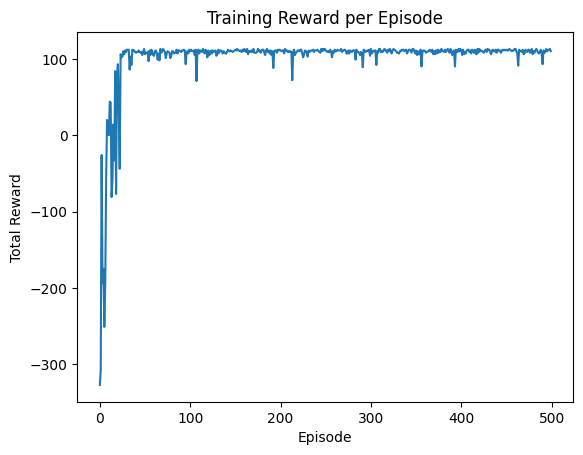

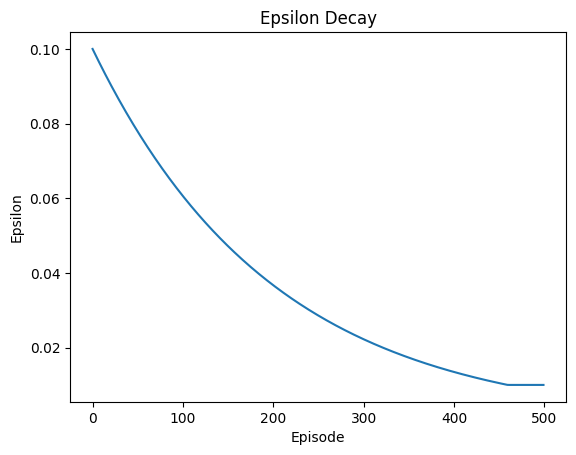

Greedy Episode 1 total reward: 111
Greedy Episode 2 total reward: 111
Greedy Episode 3 total reward: 111
Greedy Episode 4 total reward: 108
Greedy Episode 5 total reward: 109
Greedy Episode 6 total reward: 113
Greedy Episode 7 total reward: 112
Greedy Episode 8 total reward: 109
Greedy Episode 9 total reward: 112
Greedy Episode 10 total reward: 109


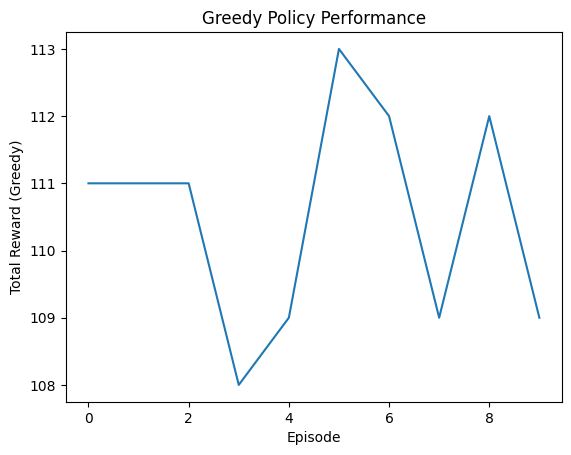


Rendering one full greedy episode:
R . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
R # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
R . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. R . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . R P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . R P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . R # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . R . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . R . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . R D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . R

. . . . . .
. #

In [42]:
Q = defaultdict(lambda: np.zeros(n_actions))
rewards_per_episode ,epsilons = train_loop(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

print("\nTrained Q-table (first 10 states):")
for state in list(Q.keys())[:10]:
    print(f"{state}: {Q[state]}")

with open("Q_table2.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode")
plt.show()

plt.figure()
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()

greedy_rewards = test_loop()

plt.figure()
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Greedy)")
plt.title("Greedy Policy Performance")
plt.show()

print("\nRendering one full greedy episode:")
obs, _ = env.reset()
state = tuple(obs)
done = False
env.render()
while not done:
    action = np.argmax(Q[state])
    next_obs, reward, done, _, _ = env.step(action)
    state = tuple(next_obs)
    env.render()
print("Episode finished.\n")

- Q-learning on Stochastic Env
- Model Iteration 1
> Hyperparameters 
> 
>Exploration
>
> epsilon = 0.1 (90% exploit)
> 
> gamma = 0.99 (high learning , attains max rewards faster)
> 
> decay_rate = 0.995 (slow decay it affects the reward curve)
> 
> epsilon min = 0.01(low value that mean first explore and then exploit in the end of graph)
> 
> episodes =500
> 
> steps = 200

Training finished.
Average reward : 100.86

Trained Q-table (first 10 states):
(np.int8(0), np.int8(0), np.int8(0)): [ 1.27467476e+02 -2.59841183e+00  6.22142747e+01  2.75658135e+03
  1.18416591e+02  5.78206566e+02]
(np.int8(1), np.int8(0), np.int8(0)): [-2.1435043  -1.99074088 -2.16717761 -5.58467494 -2.16561584 -2.17705327]
(np.int8(0), np.int8(1), np.int8(0)): [ 402.95277856  208.00386642  354.54091232 2858.14980778  358.45297903
  159.84208778]
(np.int8(0), np.int8(2), np.int8(0)): [  46.06716916  250.39920724   65.07275723 2953.80451096  178.94124265
   42.3598512 ]
(np.int8(0), np.int8(3), np.int8(0)): [ 2.42028896e+02  3.04873514e+03  2.22164041e+00 -7.08879227e-01
  2.32953621e+02  5.11414904e+01]
(np.int8(1), np.int8(3), np.int8(0)): [  24.27490074 3149.9896701   339.58263547  104.3280333   302.43572239
   71.08999337]
(np.int8(0), np.int8(4), np.int8(0)): [-0.499001   -0.51273489 -0.45481745 -0.47925936 -0.499001   -0.499001  ]
(np.int8(0), np.int8(5), np.int8(0)): [-0.399400

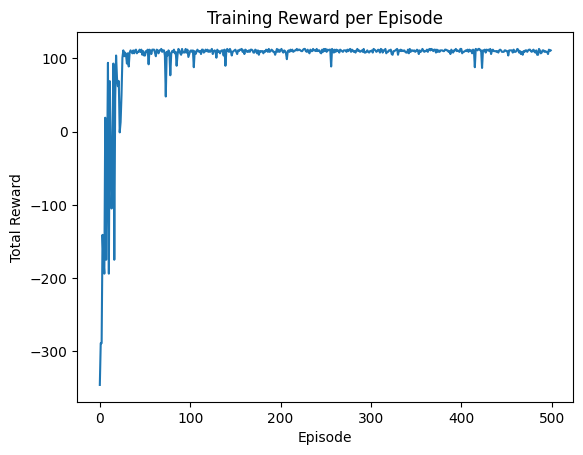

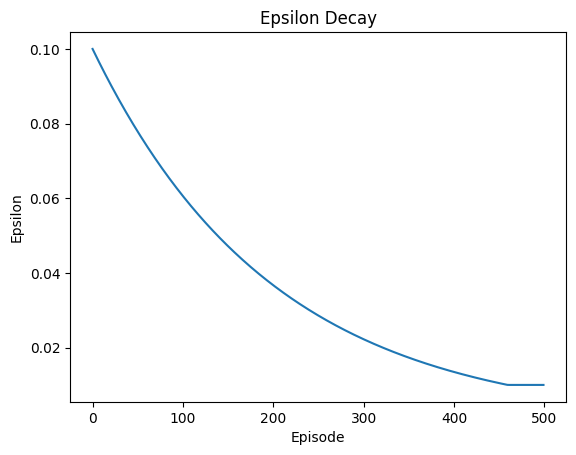

Greedy Episode 1 total reward: 111
Greedy Episode 2 total reward: 111
Greedy Episode 3 total reward: 112
Greedy Episode 4 total reward: 112
Greedy Episode 5 total reward: 111
Greedy Episode 6 total reward: 110
Greedy Episode 7 total reward: 111
Greedy Episode 8 total reward: 112
Greedy Episode 9 total reward: 108
Greedy Episode 10 total reward: 111


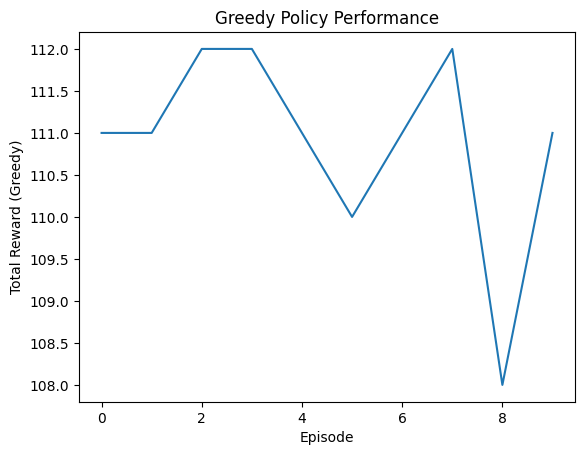


Rendering one full greedy episode:
R . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. R . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. R . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. R . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . R . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . R . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # R . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . R # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . R . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . R .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . R D

. . . . . .
. #

In [43]:
epsilon = 0.1     

Q = defaultdict(lambda: np.zeros(n_actions))
rewards_per_episode ,epsilons = train_loop(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

print("\nTrained Q-table (first 10 states):")
for state in list(Q.keys())[:10]:
    print(f"{state}: {Q[state]}")

with open("Q_table3.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode")
plt.show()

plt.figure()
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()

greedy_rewards = test_loop()

plt.figure()
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Greedy)")
plt.title("Greedy Policy Performance")
plt.show()

print("\nRendering one full greedy episode:")
obs, _ = env.reset()
state = tuple(obs)
done = False
env.render()
while not done:
    action = np.argmax(Q[state])
    next_obs, reward, done, _, _ = env.step(action)
    state = tuple(next_obs)
    env.render()
print("Episode finished.\n")

- Q-learning on Stochastic Env
-Iteration2
> Hyperparameters 
> 
>Exploration
>
> epsilon = 0.9 (10% exploit 90% explore)
> 
> gamma = 0.99 (high learning , attains max rewards faster)
> 
> decay_rate = 0.995 (slow decay it affects the reward curve)
> 
> epsilon min = 0.01(low value that mean first explore and then exploit in the end of graph)
> 
> episodes =500
> 
> steps = 200

Training finished.
Average reward : 69.08

Trained Q-table (first 10 states):
(np.int8(0), np.int8(0), np.int8(0)): [1058.08911435 2695.68058586 1248.55445936  752.98024482 1039.89058149
 1487.25693761]
(np.int8(0), np.int8(1), np.int8(0)): [ 2.09815831e-01 -1.75305410e+01  1.12029323e+03  1.90657985e+01
 -1.38707623e+00  1.08840409e+02]
(np.int8(0), np.int8(2), np.int8(0)): [  2.6020445  -14.56399988   0.59930032  61.15536955   5.67482495
   3.28873658]
(np.int8(0), np.int8(3), np.int8(0)): [ 11.83804492 187.19128014   4.71316809   6.90150658  22.42753235
  13.72832077]
(np.int8(1), np.int8(3), np.int8(0)): [  10.80306903 1618.35559069   64.51037763  110.03947109   36.09441776
   28.03455728]
(np.int8(2), np.int8(3), np.int8(0)): [ 892.33575669  831.1393219  1416.18934243  618.60038281 3195.61358262
 1071.87878372]
(np.int8(1), np.int8(4), np.int8(0)): [ -0.57088699 111.45598409   3.33788896   0.30680655   6.45989128
   4.35529999]
(np.int8(0), np.int8(4), np.int8(0)): [-1.15143282  0

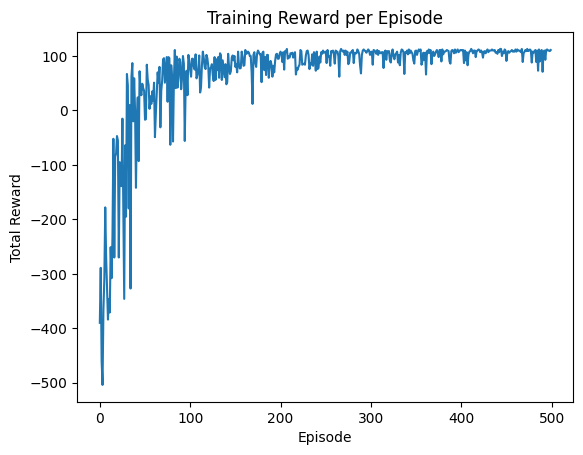

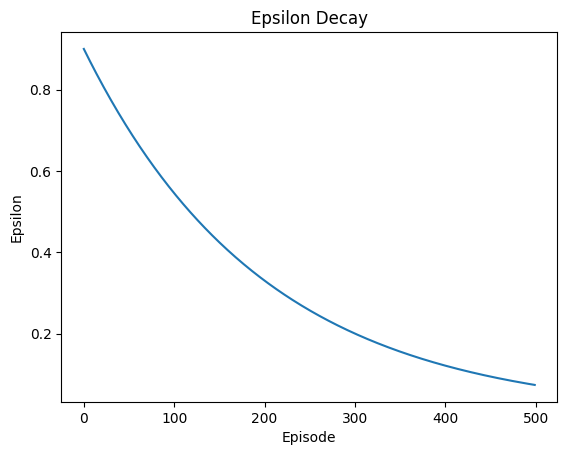

Greedy Episode 1 total reward: 111
Greedy Episode 2 total reward: 112
Greedy Episode 3 total reward: 108
Greedy Episode 4 total reward: 111
Greedy Episode 5 total reward: 111
Greedy Episode 6 total reward: 112
Greedy Episode 7 total reward: 111
Greedy Episode 8 total reward: 113
Greedy Episode 9 total reward: 108
Greedy Episode 10 total reward: 108


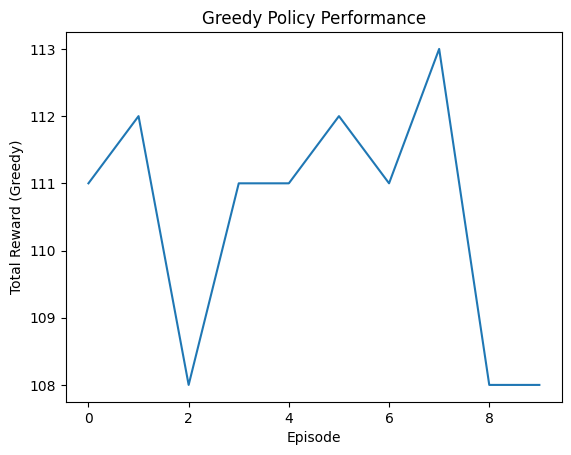


Rendering one full greedy episode:
R . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
R # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
R # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
R . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. R . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . R P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . R # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . R # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . R . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . R .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . R
. . . . . D

. . . . . .
. #

In [44]:
epsilon = 0.9     

Q = defaultdict(lambda: np.zeros(n_actions))
rewards_per_episode ,epsilons = train_loop(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

print("\nTrained Q-table (first 10 states):")
for state in list(Q.keys())[:10]:
    print(f"{state}: {Q[state]}")

with open("Q_table4.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode")
plt.show()

plt.figure()
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()

greedy_rewards = test_loop()

plt.figure()
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Greedy)")
plt.title("Greedy Policy Performance")
plt.show()

print("\nRendering one full greedy episode:")
obs, _ = env.reset()
state = tuple(obs)
done = False
env.render()
while not done:
    action = np.argmax(Q[state])
    next_obs, reward, done, _, _ = env.step(action)
    state = tuple(next_obs)
    env.render()
print("Episode finished.\n")

- Q-learning on Stochastic Env
-Iteration3
> Hyperparameters 
> 
>Exploration
>
> epsilon = 0.6 (60% explore)
> 
> gamma = 0.99 (high learning , attains max rewards faster)
> 
> decay_rate = 0.995 (slow decay it affects the reward curve)
> 
> epsilon min = 0.01(low value that mean first explore and then exploit in the end of graph)
> 
> episodes =500
> 
> steps = 200

Training finished.
Average reward : 86.93

Trained Q-table (first 10 states):
(np.int8(0), np.int8(0), np.int8(0)): [ 740.85439146 2747.92940399  668.66360645  364.02123573 1217.09005045
 1336.52560173]
(np.int8(1), np.int8(0), np.int8(0)): [1337.65119292 2830.97940992 1196.87197127 1618.58706058 1082.76332945
  983.14387214]
(np.int8(0), np.int8(1), np.int8(0)): [ -1.82995865  -2.63207762 533.4853767    5.31046071  -0.89600744
  -2.26332726]
(np.int8(0), np.int8(2), np.int8(0)): [ -1.1237565  -12.66799561  -1.61200834   1.86522987  -1.08000946
  -1.15578596]
(np.int8(0), np.int8(3), np.int8(0)): [-0.49656104 11.38551056 -1.17559796 -0.47896629  0.11192171 -0.63296153]
(np.int8(1), np.int8(3), np.int8(0)): [8.44774799e-02 9.91933432e+02 8.47384583e+00 1.46678892e+00
 4.84930915e-01 6.77833161e-01]
(np.int8(2), np.int8(3), np.int8(0)): [ 360.33221908  268.59853273  568.34806422  412.40569507 3223.32379673
 1550.62841209]
(np.int8(2), np.int8(2), np.int8(0)): [1401.33485263  212.57025768

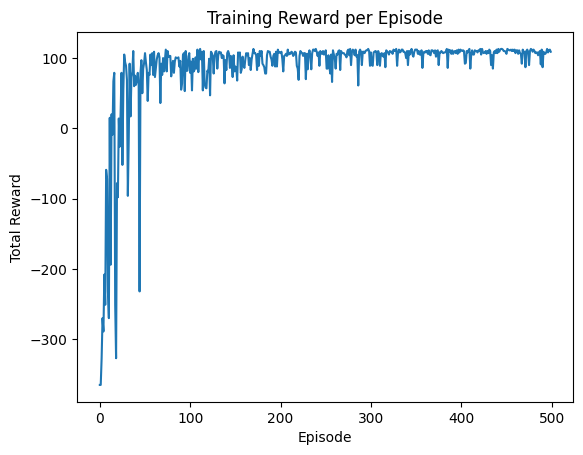

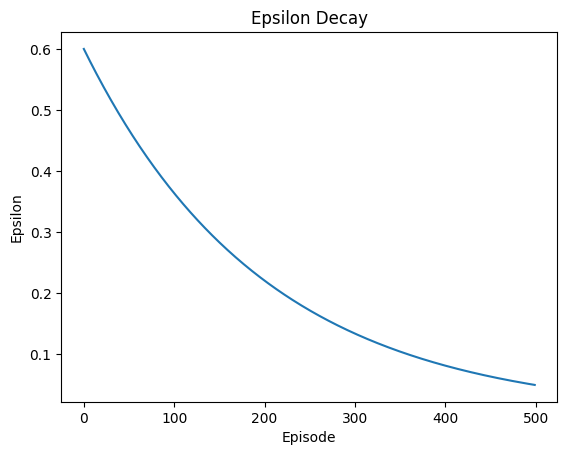

Greedy Episode 1 total reward: 109
Greedy Episode 2 total reward: 110
Greedy Episode 3 total reward: 111
Greedy Episode 4 total reward: 108
Greedy Episode 5 total reward: 108
Greedy Episode 6 total reward: 110
Greedy Episode 7 total reward: 109
Greedy Episode 8 total reward: 112
Greedy Episode 9 total reward: 110
Greedy Episode 10 total reward: 108


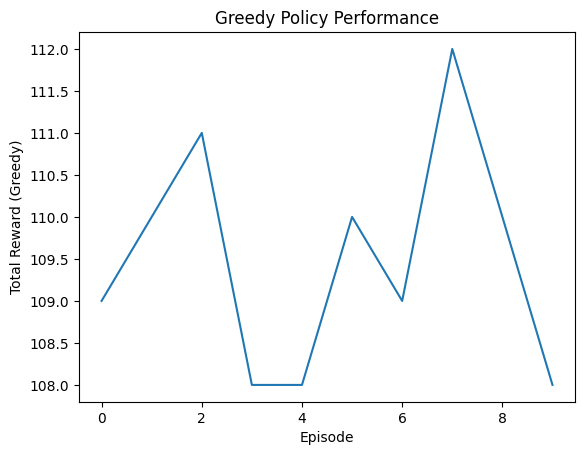


Rendering one full greedy episode:
R . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
R # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
R # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
R . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. R . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. R . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . R P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . R P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . R P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . R # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . R . .
. . . . . D

. . . . . .
. #

In [45]:
epsilon = 0.6     
Q = defaultdict(lambda: np.zeros(n_actions))
rewards_per_episode ,epsilons = train_loop(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

print("\nTrained Q-table (first 10 states):")
for state in list(Q.keys())[:10]:
    print(f"{state}: {Q[state]}")

with open("Q_table5.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode")
plt.show()

plt.figure()
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()

greedy_rewards = test_loop()

plt.figure()
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Greedy)")
plt.title("Greedy Policy Performance")
plt.show()

print("\nRendering one full greedy episode:")
obs, _ = env.reset()
state = tuple(obs)
done = False
env.render()
while not done:
    action = np.argmax(Q[state])
    next_obs, reward, done, _, _ = env.step(action)
    state = tuple(next_obs)
    env.render()
print("Episode finished.\n")

- Q-learning on Stochastic Env
-Iteration1
> Hyperparameters 
> 
>Discount Factor
>
> epsilon = 0.5 (50% explore)
> 
> gamma = 0.80 (high learning , attains max rewards fast)
> 
> decay_rate = 0.995 (slow decay it affects the reward curve)
> 
> epsilon min = 0.01(low value that mean first explore and then exploit in the end of graph)
> 
> episodes =500
> 
> steps = 200

Training finished.
Average reward : 87.78

Trained Q-table (first 10 states):
(np.int8(0), np.int8(0), np.int8(0)): [10.84681155 29.79833968  7.70973432  1.23941944 10.45437976 13.4575439 ]
(np.int8(1), np.int8(0), np.int8(0)): [16.82838713 39.42550025 20.83682798  8.47942934 15.75415742 11.41898903]
(np.int8(0), np.int8(1), np.int8(0)): [ -2.10720373 -15.14001092  -2.06471671   2.30103231  -1.9805063
  -2.02860575]
(np.int8(0), np.int8(2), np.int8(0)): [ -1.00453501 -12.60687541  -1.66722557  12.03492744  -1.11372474
  -0.94769201]
(np.int8(2), np.int8(0), np.int8(0)): [22.58925748  8.54701381 19.01681714 52.58188526 24.18840928 27.66430239]
(np.int8(3), np.int8(0), np.int8(0)): [-1.19540484 -1.19713311 -1.02272519 10.87257193 -1.16308296 -0.99529872]
(np.int8(4), np.int8(0), np.int8(0)): [-1.03677986 -1.0152253  -1.05690936 -1.01005137 -1.11223498 -1.05171874]
(np.int8(3), np.int8(1), np.int8(0)): [40.24914657  0.7539998  -0.85080259 -0.34690121 -0.4659516   5.79804827]
(np.int8(2), 

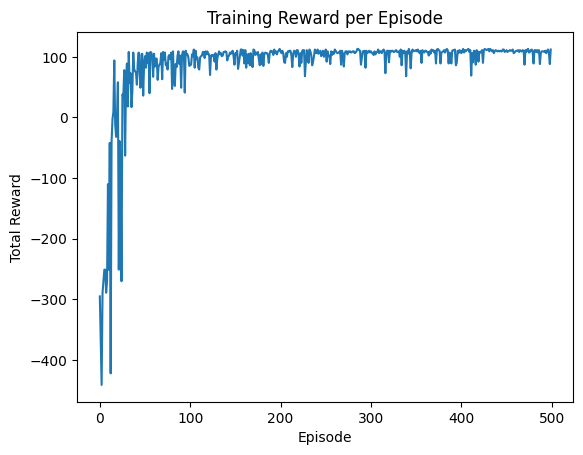

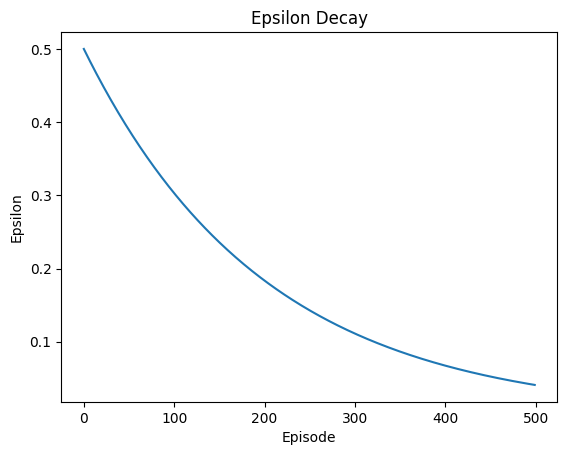

Greedy Episode 1 total reward: 112
Greedy Episode 2 total reward: 110
Greedy Episode 3 total reward: 111
Greedy Episode 4 total reward: 108
Greedy Episode 5 total reward: 110
Greedy Episode 6 total reward: 109
Greedy Episode 7 total reward: 110
Greedy Episode 8 total reward: 110
Greedy Episode 9 total reward: 112
Greedy Episode 10 total reward: 110


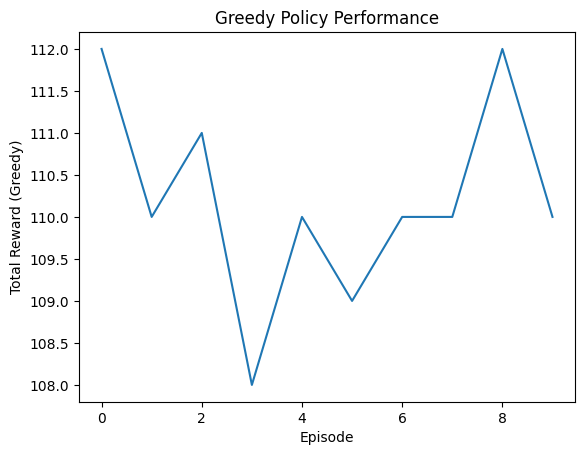


Rendering one full greedy episode:
R . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
R # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
R . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
R . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. R . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . R P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . R # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . R . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . R .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . R
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . R

. . . . . .
. #

In [46]:
gamma = 0.8       
epsilon = 0.5     
Q = defaultdict(lambda: np.zeros(n_actions))
rewards_per_episode ,epsilons = train_loop(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

print("\nTrained Q-table (first 10 states):")
for state in list(Q.keys())[:10]:
    print(f"{state}: {Q[state]}")

with open("Q_tabl8.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode")
plt.show()

plt.figure()
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()

greedy_rewards = test_loop()

plt.figure()
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Greedy)")
plt.title("Greedy Policy Performance")
plt.show()

print("\nRendering one full greedy episode:")
obs, _ = env.reset()
state = tuple(obs)
done = False
env.render()
while not done:
    action = np.argmax(Q[state])
    next_obs, reward, done, _, _ = env.step(action)
    state = tuple(next_obs)
    env.render()
print("Episode finished.\n")

- Q-learning on Stochastic Env
-Iteration2
> Hyperparameters 
> 
>Discount Factor
>
> epsilon = 0.5 (50% explore)
> 
> gamma = 0.50 (moderate learning , attains max rewards moderately)
> 
> decay_rate = 0.995 (slow decay it affects the reward curve)
> 
> epsilon min = 0.01(low value that mean first explore and then exploit in the end of graph)
> 
> episodes =500
> 
> steps = 200

Training finished.
Average reward : 87.11

Trained Q-table (first 10 states):
(np.int8(0), np.int8(0), np.int8(0)): [-1.77171447 -1.50312213 -1.76419611 -1.76337001 -1.76953859 -1.76367579]
(np.int8(1), np.int8(0), np.int8(0)): [ -1.63584306  -0.79776195  -1.49198917 -19.01316184  -1.49143642
  -1.49678937]
(np.int8(0), np.int8(1), np.int8(0)): [ -1.62402694 -10.21769596  -1.61130752  -1.51451761  -1.65615043
  -1.62446239]
(np.int8(0), np.int8(2), np.int8(0)): [ -1.30099558 -11.21225173  -1.2917239   -0.62805994  -1.23278758
  -1.26441549]
(np.int8(0), np.int8(3), np.int8(0)): [-0.51823038  2.32642275 -0.59113434 -0.46122498 -0.47183484 -0.44474728]
(np.int8(1), np.int8(3), np.int8(0)): [-0.28871565 10.33473179 -4.5652322   0.24878019  0.64840572  0.36386563]
(np.int8(0), np.int8(4), np.int8(0)): [-0.65363245 -0.6510962  -0.57687612 -0.692423   -0.6683423  -0.66851592]
(np.int8(1), np.int8(4), np.int8(0)): [-0.28525   -0.5292711 -0.35745   -0.3707625 -0.28525   -0.28525  ]
(np.int8(0)

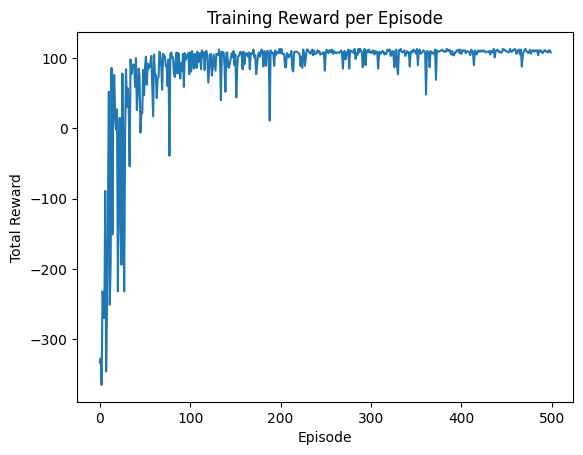

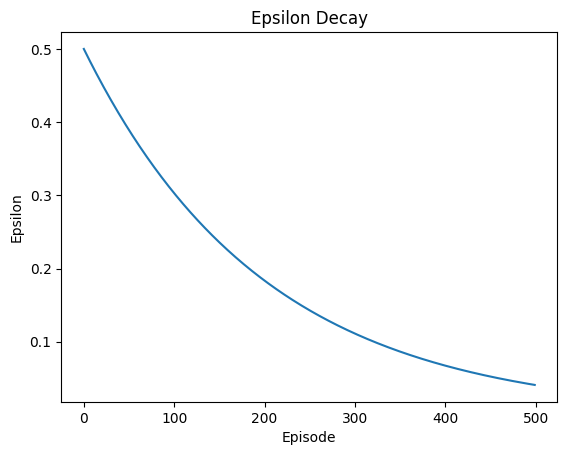

Greedy Episode 1 total reward: 111
Greedy Episode 2 total reward: 111
Greedy Episode 3 total reward: 110
Greedy Episode 4 total reward: 109
Greedy Episode 5 total reward: 112
Greedy Episode 6 total reward: 109
Greedy Episode 7 total reward: 110
Greedy Episode 8 total reward: 109
Greedy Episode 9 total reward: 111
Greedy Episode 10 total reward: 109


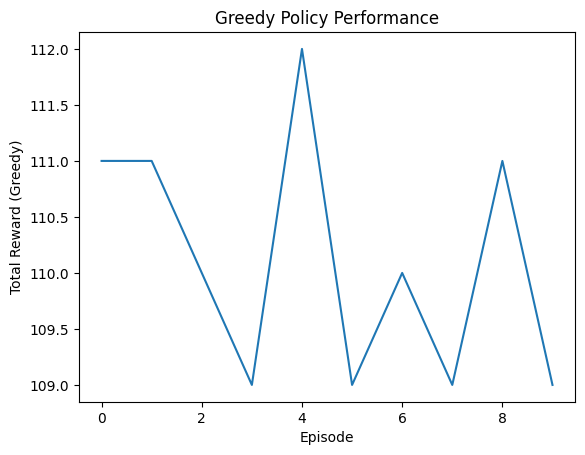


Rendering one full greedy episode:
R . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
R # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
R . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
R . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. R . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . R P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P R .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . R
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # R
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # R
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . R
. . . . . D

. . . . . .
. #

In [47]:
gamma = 0.5      
Q = defaultdict(lambda: np.zeros(n_actions))
rewards_per_episode ,epsilons = train_loop(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

print("\nTrained Q-table (first 10 states):")
for state in list(Q.keys())[:10]:
    print(f"{state}: {Q[state]}")

with open("Q_table6.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode")
plt.show()

plt.figure()
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()

greedy_rewards = test_loop()

plt.figure()
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Greedy)")
plt.title("Greedy Policy Performance")
plt.show()

print("\nRendering one full greedy episode:")
obs, _ = env.reset()
state = tuple(obs)
done = False
env.render()
while not done:
    action = np.argmax(Q[state])
    next_obs, reward, done, _, _ = env.step(action)
    state = tuple(next_obs)
    env.render()
print("Episode finished.\n")

- Q-learning on Stochastic Env
-Iteration3
> Hyperparameters 
> 
>Discount Factor
>
> epsilon = 0.5 (50% explore)
> 
> gamma = 0.10 (low learning , attains max rewards slowly)
> 
> decay_rate = 0.995 (slow decay it affects the reward curve)
> 
> epsilon min = 0.01(low value that mean first explore and then exploit in the end of graph)
> 
> episodes =500
> 
> steps = 200

Training finished.
Average reward : 66.02

Trained Q-table (first 10 states):
(np.int8(0), np.int8(0), np.int8(0)): [-1.11108085 -1.11102559 -1.11107423 -1.11105526 -1.11107297 -1.11108561]
(np.int8(1), np.int8(0), np.int8(0)): [ -1.11074792  -1.1100078   -1.11069979 -16.91115037  -1.11075804
  -1.11079817]
(np.int8(0), np.int8(1), np.int8(0)): [ -1.11031824 -18.55747846  -1.11039602  -1.11022763  -1.11031266
  -1.11043906]
(np.int8(0), np.int8(2), np.int8(0)): [ -1.10513823 -15.65206863  -1.10368747  -1.09973415  -1.10276072
  -1.10268732]
(np.int8(0), np.int8(3), np.int8(0)): [-1.05208549 -0.94085405 -1.04298755 -1.03367152 -1.05205462 -1.05173299]
(np.int8(1), np.int8(3), np.int8(0)): [-0.7291236   0.96767445 -8.6868746  -0.74468829 -0.6384232  -0.76059029]
(np.int8(2), np.int8(3), np.int8(0)): [-0.7705299  -0.69494848 -0.12850637 -0.36616592 23.88892936  1.16000372]
(np.int8(3), np.int8(3), np.int8(0)): [ 1.29263322 -0.19       -0.2775875  -5.159024   -0.40083836 -0.54977624]
(np.i

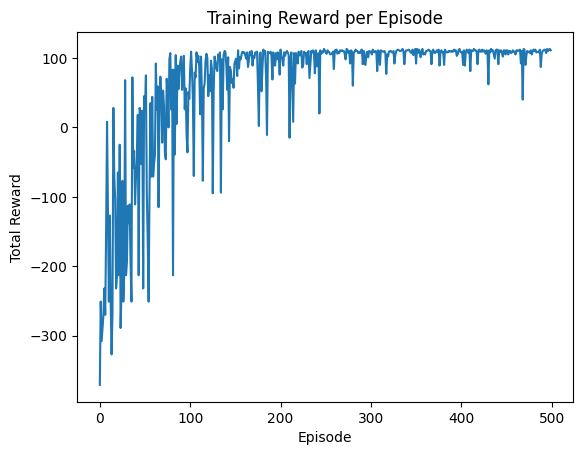

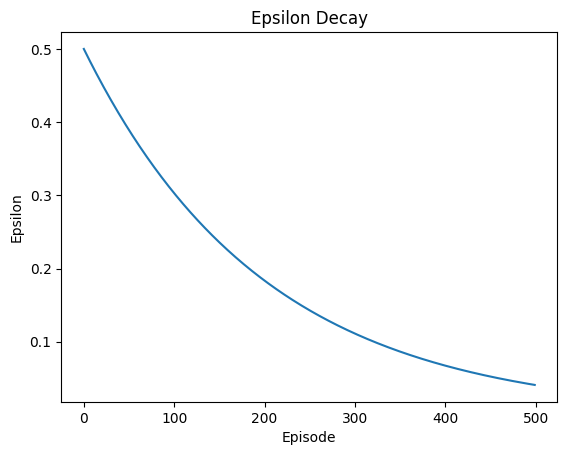

Greedy Episode 1 total reward: 111
Greedy Episode 2 total reward: 109
Greedy Episode 3 total reward: 113
Greedy Episode 4 total reward: 106
Greedy Episode 5 total reward: 111
Greedy Episode 6 total reward: 112
Greedy Episode 7 total reward: 111
Greedy Episode 8 total reward: 110
Greedy Episode 9 total reward: 113
Greedy Episode 10 total reward: 112


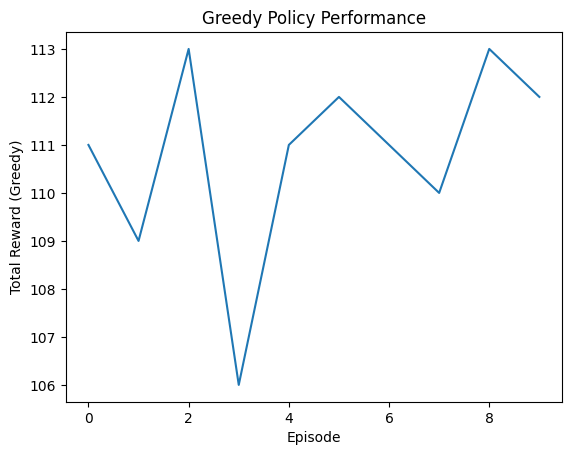


Rendering one full greedy episode:
R . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
R # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
R . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. R . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. R . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. R . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . R P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P R .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . R
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # R
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . R
. . . . . D

. . . . . .
. #

In [48]:
gamma = 0.1       
Q = defaultdict(lambda: np.zeros(n_actions))
rewards_per_episode ,epsilons = train_loop(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

print("\nTrained Q-table (first 10 states):")
for state in list(Q.keys())[:10]:
    print(f"{state}: {Q[state]}")

with open("Q_table7.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode")
plt.show()

plt.figure()
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()

greedy_rewards = test_loop()

plt.figure()
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Greedy)")
plt.title("Greedy Policy Performance")
plt.show()

print("\nRendering one full greedy episode:")
obs, _ = env.reset()
state = tuple(obs)
done = False
env.render()
while not done:
    action = np.argmax(Q[state])
    next_obs, reward, done, _, _ = env.step(action)
    state = tuple(next_obs)
    env.render()
print("Episode finished.\n")